## Regularization
Cost function = Loss + Regularization
透過 regularization，可以使的模型的weights 變得比較⼩
wi 較⼩小➔Δxi 對̂y 造成的影響(Δ̂y)較⼩小➔對 input 變化比較不敏感➔better generalization

## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [4]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [6]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [7]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

Using TensorFlow backend.


In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [======

Epoch 48/50
50000/50000 [==============================] - 9s 190us/sample - loss: 1.6156 - accuracy: 0.5225 - val_loss: 1.6744 - val_accuracy: 0.5014
Epoch 49/50
50000/50000 [==============================] - 10s 197us/sample - loss: 1.6138 - accuracy: 0.5223 - val_loss: 1.6912 - val_accuracy: 0.4921
Epoch 50/50
50000/50000 [==============================] - 9s 187us/sample - loss: 1.6089 - accuracy: 0.5247 - val_loss: 1.6650 - val_accuracy: 0.5066
Experiment with Regulizer = 0.000100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________

Epoch 45/50
50000/50000 [==============================] - 9s 185us/sample - loss: 1.0710 - accuracy: 0.6745 - val_loss: 1.5438 - val_accuracy: 0.5293
Epoch 46/50
50000/50000 [==============================] - 9s 185us/sample - loss: 1.0546 - accuracy: 0.6832 - val_loss: 1.5991 - val_accuracy: 0.5203
Epoch 47/50
50000/50000 [==============================] - 9s 187us/sample - loss: 1.0424 - accuracy: 0.6863 - val_loss: 1.5511 - val_accuracy: 0.5277
Epoch 48/50
50000/50000 [==============================] - 9s 188us/sample - loss: 1.0345 - accuracy: 0.6888 - val_loss: 1.6753 - val_accuracy: 0.4997
Epoch 49/50
50000/50000 [==============================] - 9s 186us/sample - loss: 1.0243 - accuracy: 0.6907 - val_loss: 1.5424 - val_accuracy: 0.5298
Epoch 50/50
50000/50000 [==============================] - 9s 189us/sample - loss: 1.0079 - accuracy: 0.6972 - val_loss: 1.6374 - val_accuracy: 0.5095
Experiment with Regulizer = 0.000000
Model: "model"
__________________________________________

Epoch 42/50
50000/50000 [==============================] - 9s 180us/sample - loss: 0.9764 - accuracy: 0.6566 - val_loss: 1.4271 - val_accuracy: 0.5174
Epoch 43/50
50000/50000 [==============================] - 9s 179us/sample - loss: 0.9647 - accuracy: 0.6582 - val_loss: 1.4004 - val_accuracy: 0.5187
Epoch 44/50
50000/50000 [==============================] - 9s 176us/sample - loss: 0.9519 - accuracy: 0.6651 - val_loss: 1.4982 - val_accuracy: 0.5022
Epoch 45/50
50000/50000 [==============================] - 9s 176us/sample - loss: 0.9407 - accuracy: 0.6689 - val_loss: 1.4871 - val_accuracy: 0.5121
Epoch 46/50
50000/50000 [==============================] - 9s 180us/sample - loss: 0.9254 - accuracy: 0.6749 - val_loss: 1.4182 - val_accuracy: 0.5197
Epoch 47/50
50000/50000 [==============================] - 9s 175us/sample - loss: 0.9091 - accuracy: 0.6808 - val_loss: 1.3642 - val_accuracy: 0.5323
Epoch 48/50
50000/50000 [==============================] - 9s 177us/sample - loss: 0.9040 - ac

50000/50000 [==============================] - 9s 179us/sample - loss: 1.0052 - accuracy: 0.6472 - val_loss: 1.3853 - val_accuracy: 0.5218
Epoch 40/50
50000/50000 [==============================] - 9s 178us/sample - loss: 0.9940 - accuracy: 0.6503 - val_loss: 1.3531 - val_accuracy: 0.5303
Epoch 41/50
50000/50000 [==============================] - 9s 175us/sample - loss: 0.9834 - accuracy: 0.6540 - val_loss: 1.4758 - val_accuracy: 0.5001
Epoch 42/50
50000/50000 [==============================] - 9s 175us/sample - loss: 0.9706 - accuracy: 0.6594 - val_loss: 1.3466 - val_accuracy: 0.5298
Epoch 43/50
50000/50000 [==============================] - 9s 178us/sample - loss: 0.9566 - accuracy: 0.6653 - val_loss: 1.3623 - val_accuracy: 0.5322
Epoch 44/50
50000/50000 [==============================] - 9s 175us/sample - loss: 0.9422 - accuracy: 0.6697 - val_loss: 1.3832 - val_accuracy: 0.5268
Epoch 45/50
50000/50000 [==============================] - 9s 175us/sample - loss: 0.9328 - accuracy: 0.67

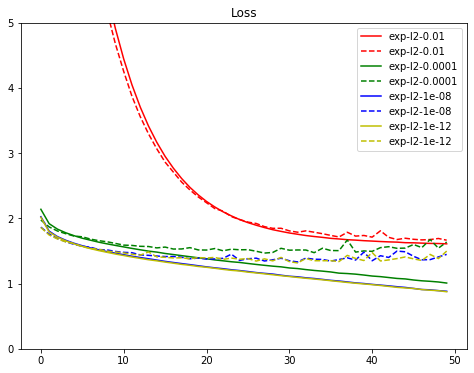

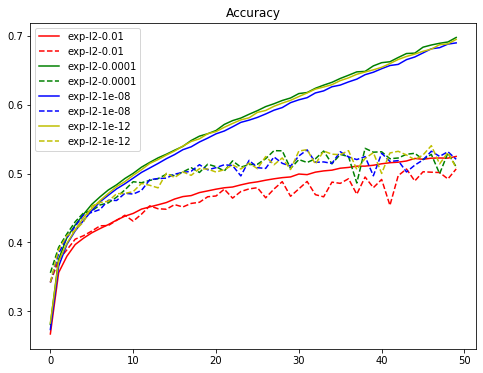

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

<img src="imgs/keras12_regulizer.png" width="70%">
<img src="imgs/keras12_regulizer1.png" width="70%">

## Dropout
在訓練時隨機將某些參參數暫時設為 0 (刻意讓訓練難度提升)，強迫模型的每個參參數有更更強的泛化能⼒力力，也讓網路路能在更更多參參數組合的狀狀態下習得表徵。

## [理解dropout](https://blog.csdn.net/stdcoutzyx/article/details/49022443)

In [1]:
from tensorflow.keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [2]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1,0.2,0.3,0.5]

In [8]:
results={}
for drop_ratio in Dropout_EXP:
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=drop_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "drop-%s" % str(drop_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0     

50000/50000 [==============================] - 9s 173us/sample - loss: 1.1774 - accuracy: 0.5740 - val_loss: 1.3283 - val_accuracy: 0.5317
Epoch 46/50
50000/50000 [==============================] - 8s 167us/sample - loss: 1.1710 - accuracy: 0.5811 - val_loss: 1.3423 - val_accuracy: 0.5266
Epoch 47/50
50000/50000 [==============================] - 8s 168us/sample - loss: 1.1624 - accuracy: 0.5805 - val_loss: 1.3248 - val_accuracy: 0.5342
Epoch 48/50
50000/50000 [==============================] - 9s 180us/sample - loss: 1.1656 - accuracy: 0.5762 - val_loss: 1.3271 - val_accuracy: 0.5329
Epoch 49/50
50000/50000 [==============================] - 9s 176us/sample - loss: 1.1500 - accuracy: 0.5847 - val_loss: 1.3647 - val_accuracy: 0.5178
Epoch 50/50
50000/50000 [==============================] - 9s 176us/sample - loss: 1.1498 - accuracy: 0.5857 - val_loss: 1.3404 - val_accuracy: 0.5241
Model: "model_1"
_________________________________________________________________
Layer (type)           

50000/50000 [==============================] - 9s 171us/sample - loss: 1.4127 - accuracy: 0.4875 - val_loss: 1.3956 - val_accuracy: 0.5056
Epoch 40/50
50000/50000 [==============================] - 8s 169us/sample - loss: 1.4031 - accuracy: 0.4969 - val_loss: 1.3713 - val_accuracy: 0.5089
Epoch 41/50
50000/50000 [==============================] - 9s 179us/sample - loss: 1.4054 - accuracy: 0.4957 - val_loss: 1.3961 - val_accuracy: 0.5092
Epoch 42/50
50000/50000 [==============================] - 8s 165us/sample - loss: 1.4026 - accuracy: 0.4926 - val_loss: 1.4006 - val_accuracy: 0.4957
Epoch 43/50
50000/50000 [==============================] - 8s 163us/sample - loss: 1.4062 - accuracy: 0.4947 - val_loss: 1.3906 - val_accuracy: 0.5082
Epoch 44/50
50000/50000 [==============================] - 8s 166us/sample - loss: 1.3892 - accuracy: 0.5003 - val_loss: 1.3832 - val_accuracy: 0.5072
Epoch 45/50
50000/50000 [==============================] - 9s 175us/sample - loss: 1.3956 - accuracy: 0.49

50000/50000 [==============================] - 8s 167us/sample - loss: 1.6030 - accuracy: 0.4217 - val_loss: 1.5311 - val_accuracy: 0.4626
Epoch 34/50
50000/50000 [==============================] - 8s 168us/sample - loss: 1.6057 - accuracy: 0.4212 - val_loss: 1.5473 - val_accuracy: 0.4613
Epoch 35/50
50000/50000 [==============================] - 8s 170us/sample - loss: 1.6046 - accuracy: 0.4219 - val_loss: 1.5525 - val_accuracy: 0.4533
Epoch 36/50
50000/50000 [==============================] - 11s 222us/sample - loss: 1.6030 - accuracy: 0.4226 - val_loss: 1.5295 - val_accuracy: 0.4569
Epoch 37/50
50000/50000 [==============================] - 10s 192us/sample - loss: 1.5942 - accuracy: 0.4250 - val_loss: 1.5433 - val_accuracy: 0.4572
Epoch 38/50
50000/50000 [==============================] - 9s 174us/sample - loss: 1.5989 - accuracy: 0.4234 - val_loss: 1.5914 - val_accuracy: 0.4366
Epoch 39/50
50000/50000 [==============================] - 9s 171us/sample - loss: 1.5959 - accuracy: 0.

50000/50000 [==============================] - 9s 179us/sample - loss: 1.9610 - accuracy: 0.2611 - val_loss: 1.9832 - val_accuracy: 0.2781
Epoch 28/50
50000/50000 [==============================] - 9s 175us/sample - loss: 1.9674 - accuracy: 0.2572 - val_loss: 1.9663 - val_accuracy: 0.2747 loss: 1.9698 
Epoch 29/50
50000/50000 [==============================] - 10s 197us/sample - loss: 1.9582 - accuracy: 0.2622 - val_loss: 2.0175 - val_accuracy: 0.2434
Epoch 30/50
50000/50000 [==============================] - 9s 185us/sample - loss: 1.9606 - accuracy: 0.2614 - val_loss: 1.9592 - val_accuracy: 0.3007
Epoch 31/50
50000/50000 [==============================] - 8s 168us/sample - loss: 1.9603 - accuracy: 0.2614 - val_loss: 2.0276 - val_accuracy: 0.2694
Epoch 32/50
50000/50000 [==============================] - 9s 175us/sample - loss: 1.9546 - accuracy: 0.2623 - val_loss: 2.0192 - val_accuracy: 0.2831
Epoch 33/50
50000/50000 [==============================] - 9s 172us/sample - loss: 1.9504 -

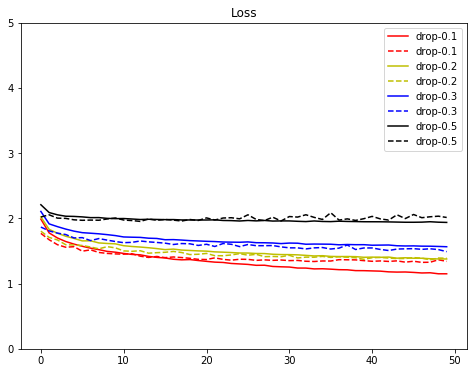

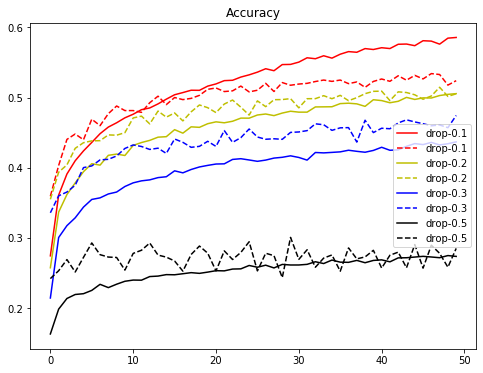

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "y", "b","k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Batch normaliztion
> 除了了在 Inputs 做正規化以外，批次正規層讓我們能夠將每⼀層的輸入/輸出做正規化

> 各層的正規化使得 Gradient 消失 (gradient vanish) 或爆炸 (explode) 的狀狀況得以減輕 (但最近有paper對於這項論點有些不同意)

- 每個 input feature 獨立做 normalization
- 利用 batch statistics 做 normalization ⽽而非整份資料
- 同一筆資料在不同的 batch 中會有些微不同
- Batch Normalization可以解決 Gradient vanishing 的問題
- 可以⽤用比較⼤大的 learning rate
- 加速訓練
- 取代 dropout & regularizes
- 目前⼤大多數的 Deep neural network 都會加


### [莫煩——批標準化](https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-08-batch-normalization/)
在神经网络中, 数据分布对训练会产生影响. 比如某个神经元 x 的值为1, 某个 Weights 的初始值为 0.1, 这样后一层神经元计算结果就是 Wx = 0.1; 又或者 x = 20, 这样 Wx 的结果就为 2. 现在还不能看出什么问题, 但是, 当我们加上一层激励函数, 激活这个 Wx 值的时候, 问题就来了. 如果使用 像 tanh 的激励函数, Wx 的激活值就变成了 ~0.1 和 ~1, 接近于 1 的部已经处在了 激励函数的饱和阶段, 也就是如果 x 无论再怎么扩大, tanh 激励函数输出值也还是 接近1. 换句话说, 神经网络在初始阶段已经不对那些比较大的 x 特征范围 敏感了. 这样很糟糕, 想象我轻轻拍自己的感觉和重重打自己的感觉居然没什么差别, 这就证明我的感官系统失效了. 当然我们是可以用之前提到的对数据做 normalization 预处理, 使得输入的 x 变化范围不会太大, 让输入值经过激励函数的敏感部分. 但刚刚这个不敏感问题不仅仅发生在神经网络的输入层, 而且在隐藏层中也经常会发生.

<img src="imgs/keras12_batch normalization.png" width="90%">
<img src="imgs/keras12_batch normalization1.png" width="90%">

我们引入一些 batch normalization 的公式. 这三步就是我们在刚刚一直说的 normalization 工序, 但是公式的后面还有一个反向操作, 将 normalize 后的数据再扩展和平移. 原来这是为了让神经网络自己去学着使用和修改这个扩展参数 gamma, 和 平移参数 β, 这样神经网络就能自己慢慢琢磨出前面的 normalization 操作到底有没有起到优化的作用, 如果没有起到作用, 我就使用 gamma 和 belt 来抵消一些 normalization 的操作.

<img src="imgs/keras12_batch normalization2.png" width="90%">

### [Batch Normalization原理与实战](https://zhuanlan.zhihu.com/p/34879333)

#### 优势
- BN使得网络中每层输入数据的分布相对稳定，加速模型学习速度
- BN使得模型对网络中的参数不那么敏感，简化调参过程，使得网络学习更加稳定
- BN允许网络使用饱和性激活函数（例如sigmoid，tanh等），缓解梯度消失问题
- BN具有一定的正则化效果

## 範例重點
* 學習如何在 keras 中加入 BatchNorm
* 知道有無 BN 對訓練的影響
* 比較 BN 在不同 batch size 下的效果

In [10]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x) 
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [16, 64, 256, 1024]
MOMENTUM = 0.95

In [12]:
results={}
for batchsize in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batchsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "batchsize-%s" % str(batchsize)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               3289

50000/50000 [==============================] - 49s 987us/sample - loss: 0.5968 - accuracy: 0.7881 - val_loss: 1.5990 - val_accuracy: 0.5473
Epoch 46/50
50000/50000 [==============================] - 49s 976us/sample - loss: 0.5843 - accuracy: 0.7924 - val_loss: 1.6309 - val_accuracy: 0.5520
Epoch 47/50
50000/50000 [==============================] - 49s 989us/sample - loss: 0.5768 - accuracy: 0.7949 - val_loss: 1.6166 - val_accuracy: 0.5507
Epoch 48/50
50000/50000 [==============================] - 49s 979us/sample - loss: 0.5721 - accuracy: 0.7971 - val_loss: 1.6209 - val_accuracy: 0.5510
Epoch 49/50
50000/50000 [==============================] - 52s 1ms/sample - loss: 0.5632 - accuracy: 0.8002 - val_loss: 1.6559 - val_accuracy: 0.5514
Epoch 50/50
50000/50000 [==============================] - 78s 2ms/sample - loss: 0.5599 - accuracy: 0.8013 - val_loss: 1.6437 - val_accuracy: 0.5510
Model: "model_5"
_________________________________________________________________
Layer (type)         

50000/50000 [==============================] - 26s 524us/sample - loss: 0.8734 - accuracy: 0.7066 - val_loss: 1.4129 - val_accuracy: 0.5202
Epoch 12/50
50000/50000 [==============================] - 26s 519us/sample - loss: 0.8217 - accuracy: 0.7270 - val_loss: 1.4317 - val_accuracy: 0.5185
Epoch 13/50
50000/50000 [==============================] - 27s 531us/sample - loss: 0.7723 - accuracy: 0.7444 - val_loss: 1.4613 - val_accuracy: 0.5123
Epoch 14/50
50000/50000 [==============================] - 26s 519us/sample - loss: 0.7218 - accuracy: 0.7634 - val_loss: 1.4739 - val_accuracy: 0.5153
Epoch 15/50
50000/50000 [==============================] - 27s 530us/sample - loss: 0.6737 - accuracy: 0.7837 - val_loss: 1.4774 - val_accuracy: 0.5219
Epoch 16/50
50000/50000 [==============================] - 29s 588us/sample - loss: 0.6259 - accuracy: 0.7997 - val_loss: 1.5038 - val_accuracy: 0.5196
Epoch 17/50
50000/50000 [==============================] - 27s 532us/sample - loss: 0.5769 - accurac

50000/50000 [==============================] - 22s 444us/sample - loss: 1.5038 - accuracy: 0.4724 - val_loss: 1.6898 - val_accuracy: 0.4062
Epoch 6/50
50000/50000 [==============================] - 23s 454us/sample - loss: 1.4574 - accuracy: 0.4915 - val_loss: 1.6118 - val_accuracy: 0.4290
Epoch 7/50
50000/50000 [==============================] - 22s 449us/sample - loss: 1.4159 - accuracy: 0.5056 - val_loss: 1.5558 - val_accuracy: 0.4482
Epoch 8/50
50000/50000 [==============================] - 23s 456us/sample - loss: 1.3801 - accuracy: 0.5199 - val_loss: 1.5200 - val_accuracy: 0.4611
Epoch 9/50
50000/50000 [==============================] - 22s 446us/sample - loss: 1.3467 - accuracy: 0.5311 - val_loss: 1.4957 - val_accuracy: 0.4674
Epoch 10/50
50000/50000 [==============================] - 23s 454us/sample - loss: 1.3155 - accuracy: 0.5443 - val_loss: 1.4770 - val_accuracy: 0.4742
Epoch 11/50
50000/50000 [==============================] - 23s 455us/sample - loss: 1.2858 - accuracy: 0

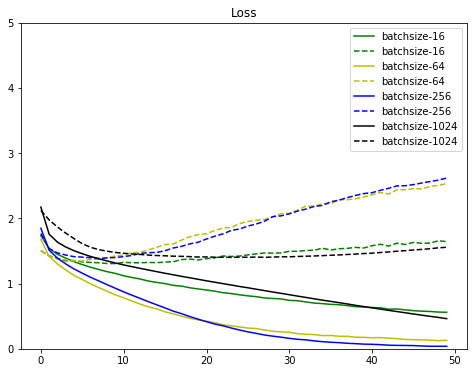

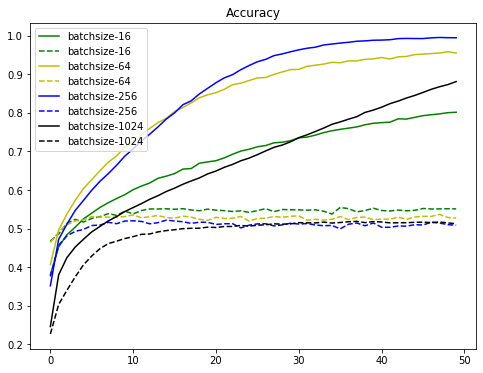

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["g", "y", "b","k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

<img src="imgs/keras12_batchsize.png">
<img src="imgs/keras12_batchsize1.png">

### Reguraliztion, Drodout, Batch Normalization

In [14]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], rdb="BatchNormalization"):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if rdb == "l1":
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(1e-8))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(input_layer)
            if rdb == "Dropout":
                x = Dropout(0.2)(x)
            if rdb == "BatchNormalization":
                x = BatchNormalization()(x)
        else:
            if rdb == "l1":
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(1e-8))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
            if rdb == "Dropout":
                x = Dropout(0.2)(x)
            if rdb == "BatchNormalization":
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 64
MOMENTUM = 0.95
RDB=["none","l1","Dropout","BatchNormalization"]

In [16]:
results={}
for rdb in RDB:
    model = build_mlp(input_shape=x_train.shape[1:],rdb=rdb)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    exp_name_tag = "overfit-%s" % rdb
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 411

50000/50000 [==============================] - 40s 790us/sample - loss: 1.6443 - accuracy: 0.4182 - val_loss: 1.5904 - val_accuracy: 0.4274
Epoch 3/50
50000/50000 [==============================] - 30s 606us/sample - loss: 1.3287 - accuracy: 0.5286 - val_loss: 1.4040 - val_accuracy: 0.5010
Epoch 9/50
50000/50000 [==============================] - 40s 796us/sample - loss: 1.2502 - accuracy: 0.5561 - val_loss: 1.4002 - val_accuracy: 0.5058
Epoch 12/50
50000/50000 [==============================] - 41s 818us/sample - loss: 1.2233 - accuracy: 0.5670 - val_loss: 1.3914 - val_accuracy: 0.5038
Epoch 13/50
50000/50000 [==============================] - 40s 807us/sample - loss: 1.1988 - accuracy: 0.5751 - val_loss: 1.3555 - val_accuracy: 0.5209
Epoch 14/50
50000/50000 [==============================] - 40s 793us/sample - loss: 1.1759 - accuracy: 0.5804 - val_loss: 1.3922 - val_accuracy: 0.5141
Epoch 15/50
50000/50000 [==============================] - 40s 802us/sample - loss: 1.1559 - accuracy:

50000/50000 [==============================] - 14s 285us/sample - loss: 1.7361 - accuracy: 0.3768 - val_loss: 1.6337 - val_accuracy: 0.4135
Epoch 4/50
50000/50000 [==============================] - 14s 279us/sample - loss: 1.6828 - accuracy: 0.3975 - val_loss: 1.5685 - val_accuracy: 0.4445
Epoch 5/50
50000/50000 [==============================] - 14s 283us/sample - loss: 1.6380 - accuracy: 0.4154 - val_loss: 1.5458 - val_accuracy: 0.4537
Epoch 6/50
50000/50000 [==============================] - 15s 293us/sample - loss: 1.6035 - accuracy: 0.4323 - val_loss: 1.5341 - val_accuracy: 0.4597
Epoch 7/50
50000/50000 [==============================] - 15s 299us/sample - loss: 1.5825 - accuracy: 0.4372 - val_loss: 1.4946 - val_accuracy: 0.4679
Epoch 8/50
50000/50000 [==============================] - 15s 298us/sample - loss: 1.5532 - accuracy: 0.4456 - val_loss: 1.4707 - val_accuracy: 0.4746
Epoch 9/50
50000/50000 [==============================] - 15s 295us/sample - loss: 1.5300 - accuracy: 0.4

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 34s 673us/sample - loss: 1.7222 - accuracy: 0.3965 - val_loss: 1.6086 - val_accuracy: 0.4321
Epoch 2/50
50000/50000 [==============================] - 32s 630us/sample - loss: 1.4939 - accuracy: 0.4737 - val_loss: 1.5551 - val_accuracy: 0.4472
Epoch 3/50
50000/50000 [==============================] - 32s 634us/sample - loss: 1.4036 - accuracy: 0.5032 - val_loss: 1.5443 - val_accuracy: 0.4540
Epoch 4/50
50000/50000 [==============================] - 31s 612us/sample - loss: 1.3367 - accuracy: 0.5281 - val_loss: 1.4816 - val_accuracy: 0.4715
Epoch 5/50
50000/50000 [==============================] - 32s 631us/sample - loss: 1.2885 - accuracy: 0.5420 - val_loss: 1.5357 - val_accuracy: 0.4636
Epoch 6/50
50000/50000 [==============================] - 29s 581us/sample - loss: 1.2420 - accuracy: 0.5608 - val_loss: 1.5045 - val_accuracy: 0.4698
Epoch 7/50
50000/50000 [====================

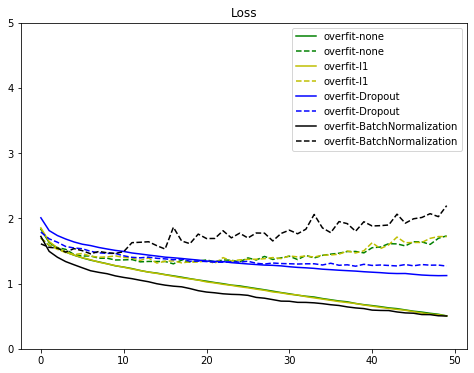

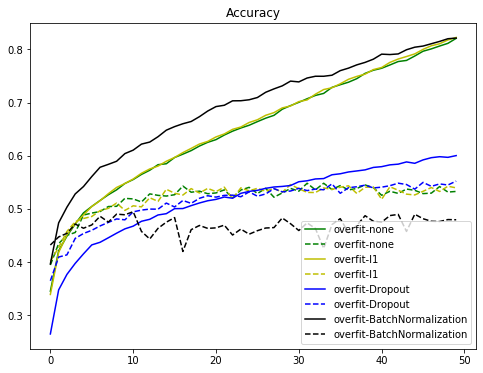

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["g", "y", "b","k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()